# Forest Cover Case Study


## Introduction:

Rasterframes is a powerful tool for combining geospatial data and spark dataframes. In this case study, we will walk through using rasterframes to conduct analysis of a forested region to determine the extent of deforestation using NDVI (Normalized Difference Vegetation Index) combined with basic machine learning techniques available through PySparkML. This tutorial assumes a basic knowledge of dataframes, more info can be found [here](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes): 

## Background:

As humans expand across the planet, land that was once forested is cleared for other activities such as farming or logging. Such land is often high in biodiversity, and while our forests are an essential feature in our ecosystem, they are being destroyed at an unsustainable rate. Gathering data on the precise regions in which this destruction is occurring allows scientists and authorities to more easily combat deforestation. Satellite data can be utilized to track and prevent deforestation, as demonstrated by this tutorial, which uses an example from the Amazon rainforest.

## Initializing the environment:

First, some imports must be made. The rasterframes library must be imported as well as Apache Spark, which serves as the processing backbone of RasterFrames. 

In [ ]:
import org.apache.spark.sql._
import astraea.spark.rasterframes._
import geotrellis.raster.io.geotiff._
import geotrellis.raster.io.geotiff.SinglebandGeoTiff
import geotrellis.raster._

Once the imports have been made, a `sparkSession` must be created. Note the `withRasterFrames()` method that is called which enables access to the rasterframes API.

In [ ]:
implicit val spark = SparkSession.builder().
  master("local[*]").appName(getClass.getName).getOrCreate().withRasterFrames
spark.sparkContext.setLogLevel("ERROR")

## Reading in a Rasterframe

Once everything has been initialized, the next step is to read in our data. This example will use data in the form of a GeoTiff, but there are other ways to create a rasterframe, including from a geotrellis `Layer`, `ProjectedExtent`, or `tileLayerRDD` (see [creating-rasterframes](../Minis/creating-rasterframes-scala.html) for more info). In the case of a geotiff, it's as simple as pointing spark.read.geotiff to the input file(s).

In [ ]:
import spark.implicits._

def readTiff(name: String): SinglebandGeoTiff = SinglebandGeoTiff(s"$name")

val filePath = "data/brazil_1/band2.tif"
val initRF = readTiff(filePath).projectedRaster.toRF(s"band_2")

## Initial analysis

Immediately, we can perform some basic functions on this rasterframe. A brief `rf.show()` will demonstrate that a rasterframe is very similar to a dataframe, with named columns corresponding to certain attributes. For instance, `tile` contains all the cell values of the image. `bounds` contains the bounds of the tiff's geometry, etc. In this way, a tiff raster can be represented as a rasterframe.

In [ ]:
initRF.show()

We can conduct some initial analysis on the tile by calling `tileStats` on the tile. The output is an array with the number of cells, number of noDataCells, min, max, mean, and variance respectively (for more on tile statistics, see [tile statistics](../Minis/statistics-scala.html)). 

In [ ]:
initRF.select(tileStats($"band_2")).show(false)

We can examine the cell type of a tile with the `cellType` command.

In [ ]:
initRF.select(cellType($"band_2")).show()

Individual stats about a tile can be obtained through the family of methods including `tileMean`, `tileSum`, `tileMin`, etc. You'll notice the output of `tileMean` is consistent with the mean value found with `tileStats`.

In [ ]:
initRF.select(tileMean($"band_2")).show()

## Loading the rest of the bands

This image is a multiband image, but we are going to load in each band individually and then perform a spatial join on the bands. This allows us to get all the bands in one rasterframe. For this demo, we are using visual and near infrared light to calculate NDVI and perform unsupervised clustering on the dataset. This means that we are loading in bands 2 through 5, which correspond to Blue, Green, Red, and NIR on the [Landsat 8 OLI](https://lta.cr.usgs.gov/L8). `spatialJoin` is a dataframe join that joins according to a spatial_key column. Bounds and metadata are discarded because they are no longer useful for the project.

This project analyzes three seperate scenes, all captured in close proximity to each other in the Brazilian rainforest. The background of this image is the green band, and it seems obvious from a brief look at this band that there is deforestation occurring at all three sites.

![Pic](pics/site_locs.png)

In [ ]:
// Three scenes
val sceneNums = 1 to 3
// Four bands per scene (2, 3, 4, and 5)
val bandNums = 2 to 5

val filePattern = "data/brazil_%d/band%d.tif"                         

Create the name of the files that we will need to read. Then, read all those files in and convert them to RasterFrames. Finally, perform a spatial join on the list of rasterframes containing only one band as a tile to create a larger RasterFrame.

In [ ]:
val fullRFs = sceneNums.map{sn => bandNums.map { bn => (bn, filePattern.format(sn, bn))}
                   .map{bandFile => readTiff(bandFile._2).projectedRaster.toRF("band_%d".format(bandFile._1))}
                   .reduce(_ spatialJoin _)}

As you can see, all four bands of all three scenes are now loaded into three seperate rasterframes.

In [ ]:
for (rf <- fullRFs) rf.show()

In addition, it is possible to display the center of the extent of the tile in (Lat, Long) format. The method `withCenter` will display it in the native CRS, and `withBounds` and `withSpatialIndex` also exist.

In [ ]:
fullRFs.apply(0).withCenterLatLng().select("center").show(1, false)

## Feature Engineering

This example uses [NDVI](../Minis/ndvi-scala.html), which is a metric computed from the normalized difference between two of our bands, the NIR band (band 5), and the red band (band 4). We will add another column, this time with the tiles as the normalized difference between the NIR and red bands for each scene. In addition, it is sometimes useful to compute additional relationships between bands to use as features in a machine learning algorithm. Additionally, the cell types of the NIR and red bands are converted to floats for the purposes of stability with `convertCellType`, which changes the data type of the cells in a tile. The diagram below is a local function that operates on colors (See [Tile Arithmetic](../Minis/tile-arithmetic-scala.html) for more information on map algebra).

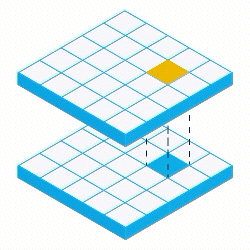

In [ ]:
val ndviRFs = fullRFs.map { rf => rf.withColumn("ndvi",
        normalizedDifference(convertCellType($"band_5", "float32"), convertCellType($"band_4", "float32"))) }

Normalized difference is a local function that is equivalent to $\frac{NIR - Red}{NIR + Red}$. Local functions perform functions on a cellwise basis. Every cell in a band has corresponding cells in another band, and the output of a local function is a tile where the cell values are determined by some function that operates on every cell individually. We will find the sum of the green and blue bands to use in our clustering model. `localAdd` is part of a family of arithemtic functions, and it adds the values of every corresponding cell together to produce an output cell. There also exist local scalar arithmetic functions, which you must append "Int" to to use with an integer.

In [ ]:
val completeRFs = ndviRFs.map { rf => rf.withColumn("grvi",
        normalizedDifference(convertCellType($"band_3", "float32"), convertCellType($"band_4", "float32"))) }

In [ ]:
for (rf <- completeRFs) rf.select(tileStats($"ndvi")).show(false)

## Machine learning

The purpose of this demonstration is to determine the extent of deforestation in the selected areas in a procedural way. To this end, we will use a straightforward [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering algorithm available to us through SparkML. K-means operates by establishing k cluster centers and then assigning every observation to a cluster based on the distance it is from the cluster center. The location of the cluster centers are moved to be the centroid of the observations, and the process is repeated until convergence occurs (For another example of clustering, see [clustering](../Minis/clustering.html)). 

These are the tile stats for the NDVI, GRVI, and infrared bands for the first scene.

In [ ]:
completeRFs.apply(0).select(tileStats($"ndvi")).show()
completeRFs.apply(0).select(tileStats($"grvi")).show()
completeRFs.apply(0).select(tileStats($"band_5")).show()

Recall that k-means uses the euclidean distance between two features to assign cluster values to each cell, which is the distance in 6 dimensional space where the six feature dimensions are the four bands and the two indexes we created. However, as we can see from the tile stats, ndvi and grvi are between 0 and 1 while the bands have values in the thousands. This means that the distance between any two points will be largely determined by the band values, which defeats the point of using our vegetation indexes. One solution is to scala the value of the indexes to be more significant.

In [ ]:
val scaledRFs = completeRFs.map { rf => rf.withColumn("ndvi_s", localMultiplyScalar($"ndvi", 500.0))
    .withColumn("grvi_s", localMultiplyScalar($"grvi", 500.0)) }

### Pipeline

The algorithm works through assigning features to clusters. PySparkML requires that each feature be in its own row, and those features be packed into a single `Vector`. This means that all the information must be packed into a single feature vector. The first step is to "explode" the tiles into a single row per cell/pixel, so the top left cell is assigned its own row, with the cellwise values of every band as the values in that row.

In [ ]:
import astraea.spark.rasterframes.ml.TileExploder

val exploder = new TileExploder()

In [ ]:
val bandColNames = bandNums.map { x => "band_%d".format(x) }

The next step is for the cell values in their seperate columns to be assembled into a single feature vector. PySparkML has a tool for this called a `VectorAssembler` which has as inputs a certain number of columns of features and outputs a single column with the vectorized features in it.

In [ ]:
import org.apache.spark.ml.feature.VectorAssembler

val assembler = new VectorAssembler()
    .setInputCols((bandColNames :+ ("ndvi") :+ ("grvi")).toArray)
    .setOutputCol("features")

For our example we are setting the number of clusters to 3, although the value is arbitrary.

In [ ]:
import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.clustering.{KMeans, KMeansModel}

val kmeans = new KMeans().setK(3)

// We establish our pipeline with our stages
val pipeline = new Pipeline().setStages(Array(exploder, assembler, kmeans))

Finally, we fit our model and compute our clusters

In [ ]:
val models = completeRFs.map { rf => pipeline.fit(rf) }

Upon fitting the model and transforming the data, we see the exploded data. Instead of a tile, every entry in a band contain a single pixel value. In addition, there is a prediction column that contains the result of the model's clustering.

In [ ]:
val rfModelZip = completeRFs.zip(models)

In [ ]:
val clusteredDFs = rfModelZip.map { rf_md => rf_md._2.transform(rf_md._1) }

clusteredDFs.apply(0).drop("row_index", "features").show(3)

## Visualizing Results

In order to visualize the predictions of our model, we must first convert the exploded version of the tile back into an actual tile. We must extract the spatial data from our previous rasterframe, because clusteredRFs is not a RasterFrame (RasterFrames must have a tile column, and this dataframe is full of exploded cell values).

In [ ]:
val tiledRFs = (0 to 2).map { i =>
    
    val tlm = fullRFs.apply(i).tileLayerMetadata.left.get

    clusteredDFs.apply(i).groupBy($"spatial_key").agg(
        assembleTile(
            $"column_index", $"row_index", $"prediction",
            tlm.tileCols, tlm.tileRows, ByteConstantNoDataCellType
        )
    ).asRF
} 

To render our visualization, we convert to a raster first, and then we define colormaps and render the rasters as images.

In [ ]:
val resolutions = Seq((229, 225), (232, 246), (235, 231))

 Zip the prediction RFs and their respective resolutions to prepare to render them

In [ ]:
val zipPredsRes = tiledRFs.zip(resolutions)

val predRasters = zipPredsRes.map { pdsRes => pdsRes._1.toRaster($"prediction", pdsRes._2._2, pdsRes._2._1) }

Define our colormaps and then render the rasters.

In [ ]:
import geotrellis.raster.render._

val cmap = ColorRamp(0x0ab881FF, 0xe9aa0cFF, 0xe9e10cFF)

val cmap_r = ColorRamp(0xe9e10cFF, 0xe9aa0cFF, 0x0ab881FF)

val clusterColors = IndexedColorMap.fromColorMap(cmap.toColorMap((0 until 3).toArray))
// Reverse the aboce color
val clusterColorsReverse = IndexedColorMap.fromColorMap(cmap_r.toColorMap((0 until 3).toArray))

predRasters.apply(0).tile.renderPng(clusterColors).write("../_images/clust1.png")
predRasters.apply(1).tile.renderPng(clusterColors).write("../_images/clust2.png")
predRasters.apply(2).tile.renderPng(clusterColorsReverse).write("../_images/clust3.png")

Here are the images created by the clustering algorithm:

![](pics/scala_forest.png)

As you can see, the green closely represents forest, with the other two shades representing land that is cleared to some degree. Now let's access more precise statistics about this use by calculating tileHistograms for all three scenes.

In [ ]:
val histograms = tiledRFs.map { rf => rf.select(tileHistogram($"prediction")).first() }

In these examples, it appears that a value of zero (Green in the colormap) represents forest for scenes one and three, and 2 represents forest in scene 2. Let's find the percentage of land covered by forest in these examples by querying our histograms.

In [ ]:
// Returns the number of cells that we believe the model marked similarly to forest
val forest1 = histograms.apply(0).itemCount(0.0)
val forest2 = histograms.apply(1).itemCount(2.0)
val forest3 = histograms.apply(2).itemCount(0.0)

In the first scene, a little less than half of the scene is composed of the values that resemble rainforest (according to the model).

Number of forest divided by the total

In [ ]:
forest1 / histograms.apply(0).totalCount.toFloat

Total forest cells for all three scenes, divided by total cells

In [ ]:
(forest1 + forest2 + forest3) / 
(histograms.apply(0).totalCount + histograms.apply(1).totalCount + histograms.apply(2).totalCount).toFloat

In total, it appears that less than 40 percent of the area surveyed in these three scenes is forested. While there are improvements to be made, this algorithm could easily be adapted to survey land of any size. Landsat 8 has a temporal resolution of 16 days, and tracking these numbers over time could give an estimate of the rate of change of deforestation in a certain area, or with enough compute power, the entire Amazon Rainforest.